In [41]:
import numpy as np
import pandas as pd

from category_encoders import LeaveOneOutEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import _rebuild
_rebuild()
plt.rcParams['font.family']=['Microsoft YaHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用于正常显示负号

from statsmodels.stats.multitest import multipletests

from utilitis.feature_manager import FeatureManager

%load_ext autoreload
%autoreload 2

## 导入数据

In [3]:
def date_parser(x):
    try:
        return pd.datetime.strptime(x, "%Y%m%d")
    except:
        return np.nan

In [4]:
df = pd.read_csv('data/used_car_train_20200313.csv', sep=' ', parse_dates=['regDate', 'creatDate'], date_parser=date_parser)
print(df.shape)
df['logPrice'] = np.log(df['price'])
df.head(3)

(150000, 31)


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,logPrice
0,0,736,2004-04-02,30.0,6,1.0,0.0,0.0,60,12.5,...,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,7.522941
1,1,2262,2003-03-01,40.0,1,2.0,0.0,0.0,0,15.0,...,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,8.188689
2,2,14874,2004-04-03,115.0,15,1.0,0.0,0.0,163,12.5,...,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,8.735847


## 分类变量

变量`model`为`车型编码`，为高基类的分类型变量，从下列统计信息可以看出，count > 2000的类别只有19个

*图为各分类计数的累计和图，可以看出count值超过2000的类别其实非常少*

cate counts 248
cate count > 2000:  19


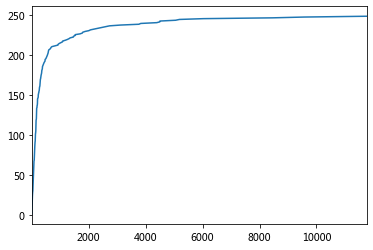

In [5]:
print('cate counts', len(df.model.value_counts()))
print('cate count > 2000: ', sum(df.model.value_counts() > 2000))
np.cumsum(df.model.value_counts().value_counts().sort_index()).plot()

再看一下计数 < 2000 和 > 2000的数据结局是否有明显差异

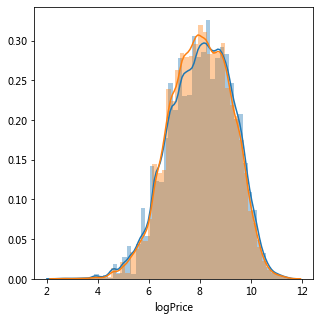

In [7]:
cut_off = 50
feat = df['regionCode']
cat_sparse = feat.value_counts()[feat.value_counts() < cut_off].index
f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.distplot(df[feat.isin(cat_sparse)]['logPrice'], hist=True, ax=ax)
sns.distplot(df[~feat.isin(cat_sparse)]['logPrice'], hist=True, ax=ax)

根据以上分析，稍后准备数据集时，我们可以把计数大于2000的类别做一个onehot，同时再新增一个target encoding

变量`'brand', 'bodyType', 'fuelType'`为分类型变量，且类别基数较小，可以直接onehot处理

变量`'regionCode'`是地区代码，但已经经过脱敏，

In [26]:
df['regionCode'].value_counts()#.plot(kind='hist', bins=20)

419     369
764     258
125     137
176     136
462     134
       ... 
6414      1
7063      1
4239      1
5931      1
7267      1
Name: regionCode, Length: 7905, dtype: int64

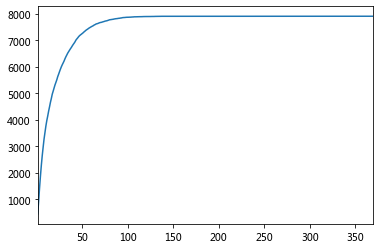

In [25]:
np.cumsum(df.regionCode.value_counts().value_counts().sort_index()).plot()

In [27]:
sum(df['regionCode'].value_counts() > 50)

649

通过设置计数阈值的方法无法有效缩减分类数量，直接用target encoding处理

## 数值变量

第一个变量是`power`，范围应该在0-600，从统计结果来看有离群点，把>600的处理为空

/opt/tljh/user/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


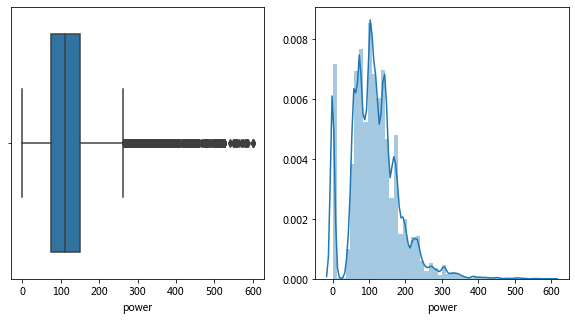

In [16]:
power = df['power']
power.loc[power > 600] = np.nan
_, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(power, ax=axes[0])
sns.distplot(power.dropna(), hist=True, ax=axes[1])

分布呈长尾且有部分数据集中为0，取log并把0值替换为nan

In [21]:
df['kilometer'].value_counts()

15.0    96877
12.5    15722
10.0     6459
9.0      5257
8.0      4573
7.0      4084
6.0      3725
5.0      3144
4.0      2718
3.0      2501
2.0      2354
0.5      1840
1.0       746
Name: kilometer, dtype: int64

`kilometer`实际是rank类型，暂时不做处理

变量`v5`、`v6`存在离群的0点，替换为nan

变量`v7`存在离群点，删掉 >0.5的数据，同理`v11`删除 >10数据，`v13`、`v14`删除 >7.5的数据

变量`v10`存在明显的3峰，尝试拆分为3个变量 ((,0], \[0, 6), (8,))

In [48]:
class MineFeatureManager(FeatureManager):
    def __init__(self, num_config=None, categorical_config=None):
        self.num_features = [
            'power', 'kilometer', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_11', 
            'v_12', 'v_13', 'v_14', 'carAge', 'v_10_1', 'v_10_2', 'v_10_3', 'modelEncode', 
            'regionCodeEncode', 'gearbox', 'notRepairedDamage', 'seller', 'offerType'
        ]
        self.categorical_features = ['model', 'brand', 'bodyType', 'fuelType']
        self.encoded_cates = ['model', 'regionCode']
        self.cate_encoder = LeaveOneOutEncoder(cols=self.encoded_cates)
        self.general_model = None
        super().__init__(self.num_features, self.categorical_features, num_config, categorical_config)

    def _feature_engien(self, features):
        zero_na = {0: np.nan}
        features = features.replace({'power': zero_na, 'v_5': zero_na, 'v_6': zero_na})
        
        features['carAge'] = (features['creatDate'] - features['regDate']).apply(lambda x: x.days)
        features['notRepairedDamage'] = features['notRepairedDamage'].replace('-', np.nan).astype(float)
        
        features.loc[features['power'] > 600, 'power'] = np.nan
        features['power'] = np.log(features['power'])
        features.loc[features['v_7'] > 0.5, 'v_7'] = np.nan
        features.loc[features['v_11'] > 10, 'v_11'] = np.nan
        features.loc[features['v_13'] > 7.5, 'v_13'] = np.nan
        features.loc[features['v_14'] > 7.5, 'v_14'] = np.nan
        
        features.loc[features['v_10'] <= 0, 'v_10_1'] = features.loc[features['v_10'] <= 0, 'v_10']
        features.loc[(features['v_10'] >= 0) & (features['v_10'] < 6), 'v_10_2'] = features.loc[(features['v_10'] >= 0) & (features['v_10'] < 6), 'v_10']
        features.loc[features['v_10'] > 8, 'v_10_3'] = features.loc[features['v_10'] > 8, 'v_10']
        features.loc[~features['model'].isin(self.general_model), 'model'] = np.nan
        return features
    
    def get_model_features(self, features):
        features = features.copy()
        self.general_model = df.model.value_counts()[df.model.value_counts() < 2000].index
        encoded_cate = self.cate_encoder.fit_transform(features, features['logPrice'])
        for cate in self.encoded_cates:
            features[cate + 'Encode'] = encoded_cate[cate]
        features = self._feature_engien(features)
        return super().get_model_features(features)
    
    def transform_feature(self, features):
        features = features.copy()
        encoded_cate = self.cate_encoder.transform(features)
        for cate in self.encoded_cates:
            features[cate + 'Encode'] = encoded_cate[cate]
        features = self._feature_engien(features)
        return super().get_model_features(features)

In [50]:
manager = MineFeatureManager(num_config={'missing_indicator': False}, categorical_config={'missing_indicator': False})
manager.get_model_features(df)

,power,kilometer,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_11,...,modelEncode,regionCodeEncode,gearbox,notRepairedDamage,seller,offerType,model,brand,bodyType,fuelType
0,4.094345,12.5,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,2.804097,...,7.305540,8.482204,0.0,0.0,0,0,NaN,6,1.0,0.0
1,NaN,15.0,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,2.096338,...,8.364457,8.683351,0.0,NaN,0,0,NaN,1,2.0,0.0
2,5.093750,12.5,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,1.803559,...,9.138945,8.077353,0.0,0.0,0,0,115.0,15,1.0,0.0
3,5.262690,15.0,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,1.285940,...,9.063679,8.030885,1.0,0.0,0,0,109.0,10,0.0,0.0
4,4.219508,5.0,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,0.910783,...,6.885260,9.389021,0.0,0.0,0,0,110.0,5,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,5.093750,15.0,-0.736609,-1.505820,0.280264,0.000310,0.048441,0.071158,0.019174,-2.983973,...,8.566511,8.263583,1.0,0.0,0,0,121.0,10,4.0,0.0
149996,4.828314,10.0,-2.366699,0.698012,0.253217,0.000777,0.084079,0.099681,0.079371,-2.774615,...,8.716713,8.023668,0.0,0.0,0,0,116.0,11,0.0,0.0
149997,4.499810,6.0,-2.279091,1.423661,0.233353,0.000705,0.118872,0.100118,0.097914,-1.630677,...,7.781686,8.045319,0.0,0.0,0,0,60.0,11,1.0,1.0
149998,5.049856,15.0,-1.179812,0.620680,0.256369,0.000252,0.081479,0.083558,0.081498,-2.633719,...,8.523350,7.742092,0.0,0.0,0,0,34.0,10,3.0,1.0
